# General notes

Some lines are commented out or contain changeable parameters in functions. Search 'CHANGE' to find them. You can play around with the transformation numbers, although I don't recommend to change 'MultiplyHue' and 'LinearContrast' numbers.

# Prepare the terrain

### Record your images on a appropriate background
TL;DR: cards should be arranged vertically to the image, choose a monochrome dark background, size 720x720 or higher, take more photos of each card.<br>
<br>Take more (5+ recommended) pictures of each card and position the cards as vertically as possible (later very important). The cards should be placed on a monochrome background. I have tried different colored backgrounds and would highly recommend darker tones, e.g. dark blue, dark red or dark green.


![](rozaliste/t111.png)

These were my test images, and it turned out that pink (1.), green (4.) and yellow (5.) backgrounds do not work. My code works with darker backgrounds and does not recognize card edges properly when the card is on a light background.
A higher image resolution is recommended but not required. I took my pictures in a size of 4032x3024 pixels, but 720x720 or higher should work fine.  <br>
An alternative to photography would be to film a few seconds of video and then split the video into individual frames.

### Download backgrounds
Different backgrounds are needed for the generation of the scenes. I recommend at least a few thousand different background images. They can be found online or taken by yourself. To save time I recommend to download this set: https://www.robots.ox.ac.uk/~vgg/data/dtd/. This is the set I use, it contains about 5600 background images.

### Import resources
Make sure that you have installed all required modules.  <br>
 - OpenCV: https://github.com/opencv/opencv <br>
 - imgaug: https://github.com/aleju/imgaug <br>
 - Shapely: https://github.com/Toblerity/Shapely <br>
 - tqdm (not required): https://github.com/tqdm/tqdm <br>
 
A few additional remarks: <br>
 - Shapely may not work properly when installed from a clone. In this case, install from a .whl (wheel) file instead: https://www.lfd.uci.edu/~gohlke/pythonlibs/#shapely. Download the appropriate .whl file (for example: 'Shapely‑1.7.0‑cp37‑cp37m‑win_amd64.whl' for 64 windows and Python 3.7) and install from directory.<br>
 - tqdm is not needed, it is only used to display progress bars

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import imgaug as ia
from imgaug import augmenters as iaa
from shapely.geometry import Polygon
from shapely.geometry import box
import time
import io
import glob
from tqdm import tqdm

### Define global quantities and paths
It is important to define paths first and then use 'os.path.join', as different operating systems use different path separators. This smoothes out this difference so that cross-platform code does not have to be overloaded with special cases for each operating system. However, there is one path that you need to change manually, and that is the path for the backgrounds. My path to the backgrounds 'pathbgr' contains the Windows path separator. So if you use the same images and the same folder, make sure you change the path separator according to your operating system.

In [2]:
# Original images' size
original_imageW=4032 #CHANGE
original_imageH=3024
# Card size (239, 415) recommended
card_sizeW=239
card_sizeH=415
# Size of the final images 
# Anything above (720, 720) not recommended, it will greatly raise the computing time for detection learning
final_imageW=720
final_imageH=720
# Name of the folder where original images are stored
pathoriginal='images_original'
# Name of the folder where cropped images will be stored
pathcrop='images_crop'
# Name of the folder where contours of cropped images will be stoed
pathcont='images_contours'
# Name of the folder where the final data will be stored
pathscene='scene'
# Name of the main folder where background folders with background images will be stored
# If all of your backgrounds are in one folder then that is your main folder
pathbgr='dtd\images' #CHANGE to appropriate os path separator 

### Create classes.txt file 
In this case, 'classes' refers to objects that you want to teach the computer to recognize. For example, if you have pictures of dogs and cats, your classes are "dog" and "cat". Each line of your classes.txt file contains the name of one of your classes. In our case, we have 54 different cards, so 54 classes.

In [5]:
# Write your classes #CHANGE
names_of_classes=['Skus','Pagat', 'II', 'III','IIII','V','VI','VII','VIII','IX','X','XI','XII','XIII','XIV','XV','XVI','XVII','XVIII','XIX','XX','Mond','Kh','Dh','Ch','Bh','1h','2h','3h','4h','Kd','Dd','Cd','Bd','1d','2d','3d','4d','Ks','Ds','Cs','Bs','10s','9s','8s','7s','Kc','Dc','Cc','Bc','10c','9c','8c','7c']

# First check if classes.txt already exists and if so, delete it
if os.path.exists(os.path.join(pathscene,'classes.txt')):
    os.remove(os.path.join(pathscene,'classes.txt'))

# Create classes.txt and append names_of_classes
f=open(os.path.join(pathscene, 'classes.txt' ),'a')
for i in range(len(names_of_classes)):
    if i<len(names_of_classes)-1: 
        f.write(names_of_classes[i]+'\n')
    if i==len(names_of_classes)-1: 
        f.write(names_of_classes[i])
f.close()
print('File "classes.txt" was created.')

File "classes.txt" was created.


### Prepare your original images
Rename your original images according to the positions in 'names_of_classes'. In my example 'Skus' has position 0, 'Pagat' has position 1, 'II' has position 2 and so on. The image with 'Skus' card should then be renamed to '0.png' (or '0.jpg') and others according to their position.

<img src="rozaliste\original_cards_all.png" alt="Drawing" />

This is what prepared images should look like. As you can see here, not all cards were taken on the same background. Even though darker backgrounds work much better than light ones, the edges of some cards are not recognised properly even on dark backgrounds. After the first photo shoot (blue background) about a quarter of my cards were not recognised correctly, so that another photo shoot (red background) was necessary for this quarter of the cards. In total I needed 4 different backgrounds to crop all pictures correctly. The detection of object edges is very unpredictable and it is very difficult to create the "optimal" conditions for a photo shoot. If you take more pictures (even under the same conditions!) or record a video, the problem is solved.

### Prepare your background images
If you use your own backgrounds, you can ignore this step. However, make sure that your folder/folders containing background images contain only image files. If you use the same backgrounds as me, execute the cell below. Among these backgrounds there is a non-image file that needs to be deleted.

In [6]:
folder_of_file='waffled'
name_of_file='.directory'
if os.path.exists(os.path.join(pathbgr, folder_of_file, name_of_file)):
    os.remove(os.path.join(pathbgr, folder_of_file, name_of_file))
    print('Non-image file found and deleted.')
else:
    print('Non-image file already deteleted.')

Non-image file already deteleted.


# Crop the images

### Define the crop (+ contour) function
The cropping function finds cards on the original images, crops them and reduces the size of the crops. The crops are stored in a folder with the pathname 'pathcrop'. The contours are also saved in a folder with the pathname 'pathcont'. The contours outline the part of the image we want to be able to detect. We want to detect the inner part of the card, which is different on every card, i.e. we ignore the outer white edge (4 mm) of the card, which is the same on all cards.

In [7]:
def make_crop(img, cardW=card_sizeW, cardH=card_sizeH):
    # Convert a copy of original in gray color
    gray = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
    
    # Noise-reducing and edge-preserving filter
    gray=cv2.bilateralFilter(gray,11,17,17)
    
    # Edge extraction
    edge=cv2.Canny(gray,30,200)
    
    # Find the contours in the edged image, find.Contours "eats" the input, so we make a copy
    cnts, hier = cv2.findContours(edge.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # We suppose that the contour with largest area corresponds to the contour delimiting the card
    cnt = sorted(cnts, key = cv2.contourArea, reverse = True)[0]

    # Create a bounding box for that contour that will be needed later when the image will be saved
    x, y, width, height = cv2.boundingRect(cnt)
    
    # Change our image from BGR to BGRA (BGR+Alpha) to get the alpha channel in our arrays
    img=cv2.cvtColor(img,cv2.COLOR_BGR2BGRA)

    # Change Alpha of all of the pixels outside our contour to 0 to make them transparent
    fill_color = [0, 0, 0, 0] # any BGR color value to fill with
    mask_value = 255            # 1 channel white (can be any non-zero uint8 value)

    # Contours to fill outside of
    conts = [cnt]

    # Our stencil - some `mask_value` contours on black (zeros) background, 
    # The image has same height and width as `img`, but only 1 color channel
    stencil  = np.zeros(img.shape[:-1]).astype(np.uint8)
    cv2.fillPoly(stencil, conts, mask_value)

    sel      = stencil != mask_value # Select everything that is not mask_value
    img[sel] = fill_color            # And fill it with fill_color
    
    # Only save the inside of the bounding rectange that we defined before
    roi = img[y:y+height, x:x+width]
    
    # Calculate the downsize factors
    DFW=cardW/roi.shape[1]
    DFH=cardH/roi.shape[0]
    
    # Downsize the crop to (card_sizeW, card_sizeH)
    roi=cv2.resize(roi, (cardW, cardH))

    # We are only interested in the inner part of the card; everything that is inside the black edge
    # We will make the convex hull (contour, actually, since the shape is convex already) surrounding 
    # the inner edge. The inner edge has the same shape 
    # as the card itself so we can just resize the contour outlining the card

    # Find the center of our contour surronding the card
    Center=cv2.moments(cnt)
    cX = int(Center["m10"] / Center["m00"])
    cY = int(Center["m01"] / Center["m00"])

    # Calculate the scale factor. The inner contour is 4 mm away from the card edge.
    cardW=63 #63 mm
    cardH=110 #110 mm
    edge=4 #4mm CHANGE
    innerH=cardH-2*edge 
    innerW=cardW-2*edge 
    factorH=innerH/cardH # factor in y direction
    factorW=innerW/cardW # factor in x direction

    # Subtract Center from all of the countour points
    # Multiply all contour (x, y) points by downsize_factor
    # Move all the contour points back to the contour Center
    for i in range(len(cnt)):
        cnt[:,0][:,0][i]=(cnt[:,0][:,0][i]-cX)*DFW+cX
        cnt[:,0][:,1][i]=(cnt[:,0][:,1][i]-cY)*DFH+cY
    
    # Create another bounding box for the downsized contour
    x2, y2, width2, heigh2t = cv2.boundingRect(cnt)
    
    # Subtract Center from all of the countour points
    # Multiply all contour (x, y) points by the appropriate factors factorH, factorW
    # Add Center from all of the countour points
    # Substract the x2, y2 of bounding box to translate the contour to the image center
    for i in range(len(cnt)):
        cnt[:,0][:,0][i]=(cnt[:,0][:,0][i]-cX)*factorW+cX-x2
        cnt[:,0][:,1][i]=(cnt[:,0][:,1][i]-cY)*factorH+cY-y2

    return roi, cnt

### Crop the original images
When the cell below is running, a progress bar appears. Each crop takes less than 2 seconds. Do not run the cell if your images are already cropped (that is, you have already run this cell).

In [23]:
raise SystemExit('Do not run the cell below if your images are already cropped!') # Stops cell run

SystemExit: Do not run the cell below if your images are already cropped!

C:\Users\antonija8001\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [5]:
# Define the extension of the original images
images_extension='jpg'

# Crop all images in 'images_original' folder
for filename in tqdm(glob.glob(os.path.join(pathoriginal,'*.'+images_extension))):
    original=cv2.imread(filename)
    roi, cnt=make_crop(original)
    number=os.path.splitext(os.path.basename(filename))[0]
    cv2.imwrite(os.path.join(pathcrop,number+'.png'), roi)
    np.save(os.path.join(pathcont,number+'_contour'), cnt)

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:27<00:00,  1.61s/it]


### Test the crops+contours
Test crops and contours to make sure everything looks good. The contour (red line) should outline the minimum part of the card, that is different for all cards. In my case, the outer white edge of each card is ignored. Here are some of my examples of how your crops+contours should look.

<table><tr>
<td> <img src="rozaliste\c1.png" alt="Drawing" /> </td>
<td> <img src="rozaliste\c4.png" alt="Drawing" /> </td>
<td> <img src="rozaliste\c2.png" alt="Drawing" /> </td>
<td> <img src="rozaliste\c6.png" alt="Drawing" /> </td>
<td> <img src="rozaliste\c5.png" alt="Drawing" /> </td>
<td> <img src="rozaliste\c3.png" alt="Drawing" /> </td>
</tr></table>

It is not a problem at all if in some examples the contour line is not completely connected.

(415, 239, 4)


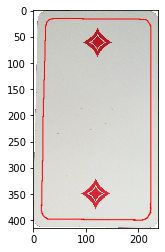

In [8]:
# Select the image you want to check
number='35'

img=cv2.imread(os.path.join(pathcrop,number+ '.png'), cv2.IMREAD_UNCHANGED)
cnt=np.load(os.path.join(pathcont,number+'_contour.npy'))

# convert to RBG and show
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGBA))
plt.plot((cnt[:,0][:,0]),(cnt[:,0][:,1]), color='red', linewidth=1)
plt.savefig('CROPCNT1.png')
print(img.shape)

# Load images

### Load a random card, load random unique cards
Load a random card from the folder 'pathcrop'. This function is used when creating scenes. The method for selecting a random card and later for selecting a random background is based on The Perl Cookbook by Tom Christiansen and Nat Torkington: https://docstore.mik.ua/orelly/perl/cookbook/ch08_07.htm. Similar to the standard 'pickle' method, this method reads lines (in our case images) but does not store them all in memory.

In [9]:
# Load a random card image and its contour from the given directory function
def load_random_image():
    n=0
    random.seed();
    for root, dirs, files in os.walk(pathcrop):
        for name in files:
            n=n+1
            if random.uniform(0, n) < 1: image_name=os.path.join(root, name)
    name=os.path.splitext(os.path.basename(image_name))[0]
    img=cv2.imread(image_name, cv2.IMREAD_UNCHANGED)
    cnt=np.load(os.path.join(pathcont,name+'_contour.npy'))
    
    return img, cnt, name

# Load two unique random card images and its contours from the given directory function
def load_two_unique_images():
    
    img1, cnt1, name1=load_random_image()
    while True:
        img2, cnt2, name2=load_random_image()
        if name1!=name2:
            break
    
    return img1, cnt1, name1, img2, cnt2, name2

# Load three unique random card images and its contours from the given directory function
def load_three_unique_images():
    
    img1, cnt1, name1=load_random_image()
    while True:
        img2, cnt2, name2=load_random_image()
        img3, cnt3, name3=load_random_image()
        if name1!=name2 and name1!=name3 and name2!=name3:
            break
    
    
    return img1, cnt1, name1, img2, cnt2, name2, img3, cnt3, name3

Random image number: 43


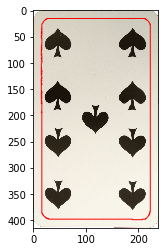

In [17]:
# TEST: load a random image
img, cnt, name=load_random_image()
print('Random image number:',name)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGBA))
plt.plot((cnt[:,0][:,0]),(cnt[:,0][:,1]), color='red', linewidth=1)

### Load a random background

In [18]:
# Load a random background from the given directory and resize it to (final_imageW, final_imageH) function
def load_random_background(fW=final_imageW, fH=final_imageH):
    n=0
    random.seed();
    for root, dirs, files in os.walk(pathbgr):
        for name in files:
            n=n+1
            if random.uniform(0, n) < 1: background_name=os.path.join(root, name)
            
    # Load a background
    background=cv2.imread(background_name)
    
    # Find maximum possible square dimension in a given image and crop it to that square
    if background.shape[0]<=background.shape[1]:
        background = background[0:background.shape[0], 0:background.shape[0]]
    else: background = background[0:background.shape[1], 0:background.shape[1]]
        
    # Resize it to the size of the final image  
    background=cv2.resize(background, (fW, fH))
    
    return background

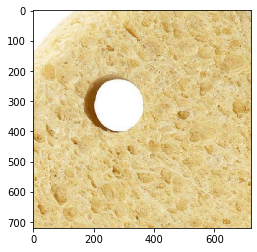

In [21]:
# TEST: load a random background
background=load_random_background()
plt.imshow(cv2.cvtColor(background,cv2.COLOR_BGR2RGB))

# Image transformations
In this part the library 'imgaug' is used. In total three affine transformations (scale, rotation, translation) and four color transformations (motion blur, linear contrast, brightness, hue) are used. The parameters for all transformations can be changed, although I only recommend to change the affine:scale and brightness transformations (iaa.Multiply) if necessary. The documentation for the transformations can be found at:<br>
https://imgaug.readthedocs.io/en/latest/index.html

In [22]:
# Overlay transparent image over background function
def image_over_background(image, background):
    
    # Overlay image over background in three steps
    # Create alpha mask
    mask_image=image[:,:,3]
    # Condition must be the same dimension as [x,y]
    mask_image=np.stack([mask_image]*3,-1) 
    # numpy.where(condition[, x, y]): Where True, yield x, otherwise yield y.
    final=np.where(mask_image,image[:,:,0:3],background) 
    
    return final

# Overlay transparent image over transparent image function
def image_over_image(image1, image2):
    
    # Overlay image over background in three steps
    # Create alpha mask
    mask_image1=image1[:,:,3]
    # Condition must be the same dimension as [x,y]
    mask_image1=np.stack([mask_image1]*4,-1) 
    # numpy.where(condition[, x, y]): Where True, yield x, otherwise yield y.
    final=np.where(mask_image1,image1[:,:,0:4],image2) 
    
    return final

In [24]:
# SINGLE image transformation
def transformation(img, cnt, biW=final_imageW, biH=final_imageH):
    # Background blank image
    blank_image = np.zeros((biH,biW,4), np.uint8)

    # We want our card to be spawned in the middle of the blank image (0,0,0,0)
    imgW=img.shape[1]
    imgH=img.shape[0]
    spawnX=int((biW-imgW)/2)
    spawnY=int((biH-imgH)/2)

    blank_image[spawnY:spawnY+imgH, spawnX:spawnX+imgW]=img
    
    # Create keypoints from the contour
    kps=[ia.Keypoint(x=p[0]+spawnX,y=p[1]+spawnY) for p in cnt.reshape(-1,2)]
    kps=ia.KeypointsOnImage(kps, shape=blank_image.shape)
    
    # Create a box Polygon covering the background
    background_area=box(0, 0, biW, biH)
    
    # Scale, translation and rotation transformations
    per=0.5 # CHANGE translation percent parameter
    
    transf_affine = iaa.Sequential([
        iaa.Affine(
            scale=[0.8,1], #CHANGE
            translate_percent={"x": (-per, per), "y": (-per, per)},
            rotate=(-180, 180)
        )
    ], random_order=True) # apply augmenters in random order
    
    # Blur, contrast, brightness and hue transformations
    transf_brightness= iaa.Sequential([
            iaa.Sometimes(
        0.04, iaa.MotionBlur(k=6, angle=[-180, 180]) # CHANGE
        ),
        iaa.LinearContrast((0.85,1.15)), # CHANGE
        iaa.Multiply((0.6, 1.15)), # CHANGE
        iaa.MultiplyHue((0.95,1.05)) # CHANGE
    ])

    # Make the 'affine' transformations
    # Calculate the union of the transformed contour polygon area and the background area
    # If it differs from the backround area itself, it means that the image transformed partialy 
    # out of the background
    # Reapeat the process of transforming the image until its contour is completely within the background
    while True:
        img_aug, kps_aug = transf_affine(image=blank_image, keypoints=kps)
        polygon = Polygon([(p.x, p.y) for p in kps_aug])
        polygon = polygon.buffer(0)
        if background_area.union(polygon).area == background_area.area:
            break
            
    # Make the 'brignthess' transformations
    # Split the channels
    b_channel, g_channel, r_channel, a_channel = cv2.split(img_aug)
    # Merge back B, G and R channels
    img_aug = cv2.merge((b_channel, g_channel, r_channel))
    # Transform
    img_aug=transf_brightness(image=img_aug)
    # Combine back with the original alpha channel
    img_aug = cv2.merge((img_aug,a_channel))
    
    
    return img_aug, kps_aug

# THREE images transformation
def transformation_hand1(img1, cnt1,img2, cnt2,img3, cnt3, biW=final_imageW, biH=final_imageH):
    
    # Calculate the 1st and 3rd image translations based on the shape of image 2
    x_trans=int(img2.shape[1]*0.5*0.8)+10
    y_trans=int((np.sqrt(img2.shape[0]**2+img2.shape[1]**2)-img2.shape[0])/2)
    
    # We want our card to be spawned in the middle of the blank image (0,0,0,0)
    imgW=img1.shape[1] # all the same shape anyways
    imgH=img1.shape[0]
    spawnX=int((biW-imgW)/2)
    spawnY=int((biH-imgH)/2)

    # Background blank image
    blank_image1 = np.zeros((biH,biW,4), np.uint8)
    blank_image1[spawnY:spawnY+imgH, spawnX:spawnX+imgW]=img1
    
    blank_image2 = np.zeros((biH,biW,4), np.uint8)
    blank_image2[spawnY:spawnY+imgH, spawnX:spawnX+imgW]=img2
    
    blank_image3 = np.zeros((biH,biW,4), np.uint8)
    blank_image3[spawnY:spawnY+imgH, spawnX:spawnX+imgW]=img3
    
    # Create Keypoints from the contour
    kps1=[ia.Keypoint(x=p[0]+spawnX,y=p[1]+spawnY) for p in cnt1.reshape(-1,2)]
    kps1=ia.KeypointsOnImage(kps1, shape=blank_image1.shape)
    
    kps2=[ia.Keypoint(x=p[0]+spawnX,y=p[1]+spawnY) for p in cnt2.reshape(-1,2)]
    kps2=ia.KeypointsOnImage(kps2, shape=blank_image2.shape)
    
    kps3=[ia.Keypoint(x=p[0]+spawnX,y=p[1]+spawnY) for p in cnt3.reshape(-1,2)]
    kps3=ia.KeypointsOnImage(kps3, shape=blank_image3.shape)
    
    # Translation and rotation transformations 1
    delta1=8 #CHANGE
    delta2=4 #CHANGE
    angle=26.8 #CHANGE
    transf_affine1 = iaa.Sequential([
        iaa.Affine(
            scale=0.8, #CHANGE
            translate_px={"x":(-x_trans-delta1, -x_trans+delta1), "y":(y_trans-delta2, y_trans+delta2)},
            rotate=(-angle-delta2, -angle+delta2) 
        )
    ], random_order=False)
    
    # Translation and rotation transformations 2
    transf_affine2 = iaa.Sequential([
        iaa.Affine(
            scale=0.8 #CHANGE
        )
    ], random_order=False)
    
    # Translation and rotation transformations 3
    transf_affine3 = iaa.Sequential([
        iaa.Affine(
            scale=0.8,
            translate_px={"x":(x_trans-delta1, x_trans+delta1), "y":(y_trans-delta2, y_trans+delta2)},
            rotate=(angle-delta2, angle+delta2)
        )
    ], random_order=False) # apply augmenters in random order
    
    # Make the 'affine' transformatons
    img_aug1, kps_aug1 = transf_affine1(image=blank_image1, keypoints=kps1)
    img_aug2, kps_aug2 = transf_affine2(image=blank_image2, keypoints=kps2)
    img_aug3, kps_aug3 = transf_affine3(image=blank_image3, keypoints=kps3)
    
    # Overlay images
    background = np.zeros((biH,biW,4), np.uint8)
    
    first=image_over_image(img_aug1, background)
    second=image_over_image(img_aug2, first)
    third=image_over_image(img_aug3, second)
    
    return third, kps_aug1, kps_aug2, kps_aug3

### Show tranformations

In [25]:
# Plot Keypoints as points function
def plot_kps(kps):
    # Convert Keypoints to points and plot them
    pts=[(kp.x,kp.y) for kp in kps]
    plt.plot([i[0] for i in pts], [i[1] for i in pts], color='red', linewidth=0.7)
    return

True

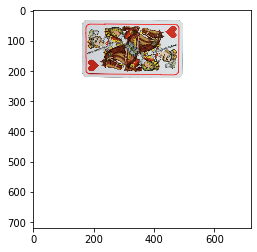

In [26]:
# TEST: show the result
img, cnt, name=load_random_image()
img_aug, kps_aug=transformation(img, cnt)
plot_kps(kps_aug)
plt.imshow(cv2.cvtColor(img_aug,cv2.COLOR_BGR2RGBA))
cv2.imwrite("trasformation_test.png", img_aug)

True

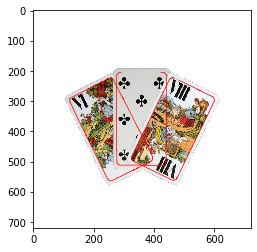

In [27]:
# TEST: show the result
img1, cnt1, name1,img2, cnt2, name2, img3, cnt3, name3=load_three_unique_images()
img_aug, kps_aug1, kps_aug2, kps_aug3=transformation_hand1(img1, cnt1,img2, cnt2,img3, cnt3)

plot_kps(kps_aug1)
plot_kps(kps_aug2)
plot_kps(kps_aug3)

plt.imshow(cv2.cvtColor(img_aug,cv2.COLOR_BGR2RGBA))
cv2.imwrite('scene3.png', img_aug)

# Create the scenes
In this part we create various final image compositions: <br>
 - The first scene contains two different cards whose contours do not overlap, <br>
 - The second scene consists of three different cards whose contours do not overlap, <br>
 - The third scene contains two different cards whose contours partially overlap. The overlapping of the contours is set to 15-30% of cards' area,
 - The fourth scene includes three different cards in a hand-holding position.

In [28]:
# Create Boundingbox from Keypoints function
def boundingbox_from_keypoints(keypoints):
    # Keypoints to contour
    contour=np.array([[kp.x, kp.y] for kp in keypoints])
    # Boundingbox from contour
    x, y, w, h = cv2.boundingRect(contour) #xmin=x, ymin=y, xmax=x+w, ymax=y+h
    return (x, y, x+w, y+h)

# Plot Boundingbox for testing function
def plot_bb(bb):
    plt.plot([bb[0], bb[0], bb[2], bb[2], bb[0]], [bb[1], bb[3], bb[3], bb[1], bb[1]], color='red')
    return

### First scene

In [29]:
# The first scene includes two cards whose contours do not overlap
def two_separate(img1, cnt1, img2, cnt2, bg):
    #transform the first image
    img_aug1, kps_aug1=transformation(img1, cnt1)
    poly1 = Polygon([(p.x, p.y) for p in kps_aug1])
    poly1 = poly1.buffer(0)
    
    # Transform the second image
    # If the contours area interesection is not 0, transform the second image again
    while True:
        img_aug2, kps_aug2=transformation(img2, cnt2)
        poly2 = Polygon([(p.x, p.y) for p in kps_aug2])
        poly2 = poly2.buffer(0)
        if poly1.intersection(poly2).area == 0:
            break
         
    # Overlay image1 over background
    first=image_over_background(img_aug1, bg)
    
    # Overlay image2 over the first result
    second=image_over_background(img_aug2, first)
    
    # Create BoundingBox from the augmented KeyPoints
    bb1=boundingbox_from_keypoints(kps_aug1)
    bb2=boundingbox_from_keypoints(kps_aug2)

    return second, bb1, bb2

--- 0.7800374031066895 seconds ---


True

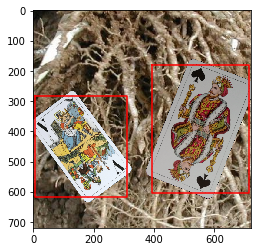

In [30]:
# TEST: show the result
start_time = time.time()
img1, cnt1, name1,img2, cnt2, name2= load_two_unique_images()
second, bb1, bb2=two_separate(img1, cnt1, img2, cnt2, load_random_background())
print("--- %s seconds ---" % (time.time() - start_time)) # typical time interval ~0.2-0.6s

plot_bb(bb1)
plot_bb(bb2)
plt.imshow(cv2.cvtColor(second,cv2.COLOR_BGR2RGBA))

cv2.imwrite("scene1_d.png", second)

### Second scene

In [31]:
# The second scene includes three cards whose contours do not overlap
def three_separate(img1, cnt1, img2, cnt2, img3, cnt3, bg):
    # transform the first image
    img_aug1, kps_aug1=transformation(img1, cnt1)
    poly1 = Polygon([(p.x, p.y) for p in kps_aug1])
    poly1 = poly1.buffer(0)
    
    # Transform the second image
    # If the contours are interesection is not 0, transform the second image again
    # Keep transforming the third image until its contours do not overlap with those of image 1 and 2
    
    while True:
        img_aug2, kps_aug2=transformation(img2, cnt2)
        poly2 = Polygon([(p.x, p.y) for p in kps_aug2])
        poly2 = poly2.buffer(0)
        if poly1.intersection(poly2).area == 0:
            break
    
    while True:
        img_aug3, kps_aug3=transformation(img3, cnt3)
        poly3 = Polygon([(p.x, p.y) for p in kps_aug3])
        poly3 = poly3.buffer(0)        
        if poly1.intersection(poly3).area == 0 and poly2.intersection(poly3).area == 0:
            break
            
            
    # Overlay image1 over background
    first=image_over_background(img_aug1, bg)
    
    # Overlay image2 over the first result
    second=image_over_background(img_aug2, first)
    
    # Overlay image3 over the second result
    third=image_over_background(img_aug3, second)

    # Create BoundingBox from the augmented KeyPoints
    bb1=boundingbox_from_keypoints(kps_aug1)
    bb2=boundingbox_from_keypoints(kps_aug2)
    bb3=boundingbox_from_keypoints(kps_aug3)
    
    return third, bb1, bb2, bb3

--- 1.7201192378997803 seconds ---


True

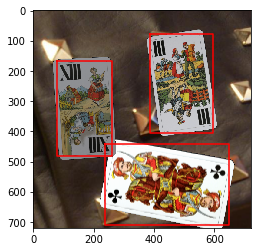

In [32]:
# TEST: show the result
start_time = time.time()
img1, cnt1, name1,img2, cnt2, name2, img3, cnt3, name3=load_three_unique_images()
third, bb1, bb2, bb3=three_separate(img1, cnt1,img2, cnt2,img3, cnt3, load_random_background())
print("--- %s seconds ---" % (time.time() - start_time)) # typical time interval ~0.6+; can be VERY high!

plot_bb(bb1)
plot_bb(bb2)
plot_bb(bb3)
plt.imshow(cv2.cvtColor(third,cv2.COLOR_BGR2RGBA))

cv2.imwrite("scene2_d.png", third)

### Third scene

In [33]:
# The third scene includes two cards whose contours partially overlap
def two_overlapping(img1, cnt1, img2, cnt2, bg):
    # Transform the first image
    img_aug1, kps_aug1=transformation(img1, cnt1)
    poly1 = Polygon([(p.x, p.y) for p in kps_aug1])
    poly1 = poly1.buffer(0)
    
    # Area of the contour 1 
    area1=poly1.area
    # Choose area overlap percentige upper and bottom limits CHANGE
    bottom=0.15 # CHANGE
    upper=0.3 # CHANGE
    
    # Transform the second image
    # If the contours area interesection is not within some percentiges of the 
    # Contour 1 area, transform the second image again
    while True:
        img_aug2, kps_aug2=transformation(img2, cnt2)
        poly2 = Polygon([(p.x, p.y) for p in kps_aug2])
        poly2 = poly2.buffer(0)
        if area1*bottom <= poly1.intersection(poly2).area <= area1*upper:
            break
         
    # Overlay image1 over background
    first=image_over_background(img_aug1, bg)
    
    # Overlay image2 over the first result
    second=image_over_background(img_aug2, first)
    
    # Create BoundingBox from the augmented KeyPoints
    bb1=boundingbox_from_keypoints(kps_aug1)
    bb2=boundingbox_from_keypoints(kps_aug2)

    
    return second, bb1, bb2

--- 0.8300597667694092 seconds ---


True

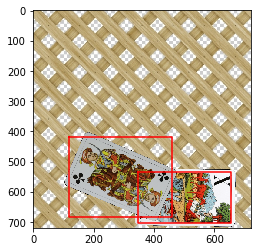

In [34]:
# TEST: show the result
start_time = time.time()
img1, cnt1, name1,img2, cnt2, name2=load_two_unique_images()
second, bb1, bb2=two_overlapping(img1, cnt1, img2, cnt2, load_random_background())
print("--- %s seconds ---" % (time.time() - start_time)) # typical time interval ~0.25s+

plot_bb(bb1)
plot_bb(bb2)
plt.imshow(cv2.cvtColor(second,cv2.COLOR_BGR2RGBA))

cv2.imwrite("scene3_overlap.png", second)

### Forth scene

In [35]:
# The forth scene includes three cards in a hand-holding position
def three_hand(img1, cnt1, img2, cnt2, img3, cnt3, bg, biW=final_imageW, biH=final_imageH):
    # Transform all three images
    img_aug, kps1, kps2, kps3=transformation_hand1(img1, cnt1,img2, cnt2,img3, cnt3)
    
    # Create a box Polygon covering the background
    background_area=box(0, 0, biW, biH)
    
    # Translation and rotation transformations
    per=0.5 # translation percent parameter CHANGE
    
    transf_affine = iaa.Sequential([
        iaa.Affine(
            scale=(0.9,1),
            translate_percent={"x": (-per, per), "y": (-per, per)},
            rotate=(-180, 180)
        )
    ], random_order=True) # apply augmenters in random order
    
    # Blur, contrast, brightness and hue transformations
    transf_brightness= iaa.Sequential([
            iaa.Sometimes(
        0.04, iaa.MotionBlur(k=6, angle=[-180, 180]) # CHANGE
        ),
        iaa.LinearContrast((0.85,1.15)), # CHANGE
        iaa.Multiply((0.6, 1.15)), # CHANGE
        iaa.MultiplyHue((0.95,1.05)) # CHANGE
    ])
    
    # Calculate Keypoints lenghts and combine them together
    len1=len(kps1)
    len2=len(kps2)
    len3=len(kps3)
    
    # Transform from KeypointsOnImage to Keypoints
    kps1=kps1[0:-1]
    kps2=kps2[0:-1]
    kps3=kps3[0:-1]
    
    kps=ia.KeypointsOnImage(kps1+ kps2+ kps3, shape=img_aug.shape)
    
    # Make the 'affine' transformations
    # Calculate the union of the transformed contour polygon area and the background area
    # If it differs from the backround area itself, it means that the image transformed partialy 
    # out of the background
    # Reapeat the process of transforming the image until its contour is completely within the background
    while True:
        img_aug_re, kps_aug = transf_affine(image=img_aug, keypoints=kps)
        
        kps_aug1=kps_aug[0:len1-1]
        poly1=Polygon([(p.x, p.y) for p in kps_aug1])
        poly1=poly1.buffer(0)

        kps_aug2=kps_aug[len1:len1+len2-2]
        poly2=Polygon([(p.x, p.y) for p in kps_aug2])
        poly2=poly2.buffer(0)

        kps_aug3=kps_aug[len1+len2:len1+len2+len3]
        poly3=Polygon([(p.x, p.y) for p in kps_aug3])
        poly3=poly3.buffer(0)

        uni1=poly1.union(poly2)

        uni2=uni1.union(poly3)

        uni3=background_area.union(uni2)

        if uni3.area == background_area.area:
            break
 
    # Make the 'brignthess' transformations
    # Split the channels
    b_channel, g_channel, r_channel, a_channel = cv2.split(img_aug_re)
    # Merge back B, G and R channels
    img_aug = cv2.merge((b_channel, g_channel, r_channel))
    # Transform
    img_aug=transf_brightness(image=img_aug)
    # Combine back with the original alpha channel
    img_aug = cv2.merge((img_aug,a_channel))
    
    # Overlay the image over background
    first=image_over_background(img_aug, bg)
    
    # Create BoundingBox from the augmented KeyPoints
    bb1=boundingbox_from_keypoints(kps_aug1)
    bb2=boundingbox_from_keypoints(kps_aug2)
    bb3=boundingbox_from_keypoints(kps_aug3)
    
    
    return first, bb1, bb2, bb3

--- 0.9100587368011475 seconds ---


True

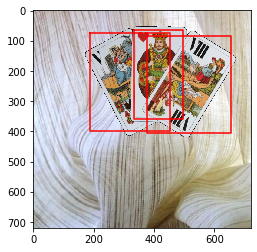

In [36]:
# TEST: show the result
start_time = time.time()
img1, cnt1, name1,img2, cnt2, name2, img3, cnt3, name3=load_three_unique_images()
first, bb1, bb2, bb3=three_hand(img1, cnt1, img2, cnt2, img3, cnt3, load_random_background())
print("--- %s seconds ---" % (time.time() - start_time)) # typical time interval ~0.25s-0.6s

plot_bb(bb1)
plot_bb(bb2)
plot_bb(bb3)
plt.imshow(cv2.cvtColor(first,cv2.COLOR_BGR2RGBA))
cv2.imwrite("scene4_pan.png", first)

# Generate synthetic data
Images should be labeled in Darknet format. For the details see: https://github.com/ultralytics/yolov3/wiki/Train-Custom-Data

In [37]:
def boudingbox_to_darknet_format(boundingbox, image):
    # Boundingbox will be given as (xmin, ymin, xmax, ymax) pixels
    xmin=boundingbox[0]
    ymin=boundingbox[1]
    xmax=boundingbox[2]
    ymax=boundingbox[3]
    
    x_center=(xmin+xmax)/2
    width=xmax-xmin
    y_center=(ymin+ymax)/2
    height=ymax-ymin
    
    # Coordinates must be normalized 
    image_width=image.shape[1]
    image_height=image.shape[0]
    
    x_center=x_center/image_width
    width=width/image_width
    y_center=y_center/image_height
    height=height/image_height
    
    return (x_center, y_center, width, height)

In [38]:
# Genereta data for the first scene function
def generate_first_scene(up):
    lower=len(glob.glob1(pathscene,'scene1_*.jpg'))
    upper=lower+up
    for i in tqdm(range(lower, upper)):
        img1, cnt1, name1,img2, cnt2, name2= load_two_unique_images()
        second, bb1, bb2=two_separate(img1, cnt1, img2, cnt2, load_random_background())
        cv2.imwrite(os.path.join(pathscene,'scene1_'+str(i)+'.jpg'), second) # save as .jpg to save some trouble later
        if os.path.exists(os.path.join(pathscene,'scene1_'+str(i)+'.txt')):
            os.remove(os.path.join(pathscene,'scene1_'+str(i)+'.txt')) # this deletes the file
        # Convert Boundingboxes to darnet format
        bb1=boudingbox_to_darknet_format(bb1, first)
        bb2=boudingbox_to_darknet_format(bb2, first)
        f= open(os.path.join(pathscene,'scene1_'+str(i)+'.txt'),'a')
        f.write(str(name1)+' '+str(bb1[0])+' '+str(bb1[1])+' '+str(bb1[2])+' '+str(bb1[3])+'\n')
        f.write(str(name2)+' '+str(bb2[0])+' '+str(bb2[1])+' '+str(bb2[2])+' '+str(bb2[3]))
        f.close()
    return

# Genereta data for the second scene function
def generate_second_scene(up):
    lower=len(glob.glob1(pathscene,'scene2_*.jpg'))
    upper=lower+up
    for i in tqdm(range(lower, upper)):
        img1, cnt1, name1,img2, cnt2, name2, img3, cnt3, name3=load_three_unique_images()
        third, bb1, bb2, bb3=three_separate(img1, cnt1,img2, cnt2,img3, cnt3, load_random_background())
        cv2.imwrite(os.path.join(pathscene,'scene2_'+str(i)+'.jpg'), third) # save as .jpg to save some trouble later
        if os.path.exists(os.path.join(pathscene,'scene2_'+str(i)+'.txt')):
            os.remove(os.path.join(pathscene,'scene2_'+str(i)+'.txt')) # this deletes the file
        # Convert Boundingboxes to darnet format
        bb1=boudingbox_to_darknet_format(bb1, first)
        bb2=boudingbox_to_darknet_format(bb2, first)
        bb3=boudingbox_to_darknet_format(bb3, first)
        f= open(os.path.join(pathscene,'scene2_'+str(i)+'.txt'),'a')
        f.write(str(name1)+' '+str(bb1[0])+' '+str(bb1[1])+' '+str(bb1[2])+' '+str(bb1[3])+'\n')
        f.write(str(name2)+' '+str(bb2[0])+' '+str(bb2[1])+' '+str(bb2[2])+' '+str(bb2[3])+'\n')
        f.write(str(name3)+' '+str(bb3[0])+' '+str(bb3[1])+' '+str(bb3[2])+' '+str(bb3[3]))
        f.close()
    return

# Genereta data for the third scene function
def generate_third_scene(up):
    lower=len(glob.glob1(pathscene,'scene3_*.jpg'))
    upper=lower+up
    for i in tqdm(range(lower, upper)):
        img1, cnt1, name1,img2, cnt2, name2=load_two_unique_images()
        second, bb1, bb2=two_overlapping(img1, cnt1, img2, cnt2, load_random_background())
        cv2.imwrite(os.path.join(pathscene,'scene3_'+str(i)+'.jpg'), second) # save as .jpg to save some trouble later
        if os.path.exists(os.path.join(pathscene,'scene3_'+str(i)+'.txt')):
            os.remove(os.path.join(pathscene,'scene3_'+str(i)+'.txt')) # this deletes the file
        # Convert Boundingboxes to darnet format
        bb1=boudingbox_to_darknet_format(bb1, first)
        bb2=boudingbox_to_darknet_format(bb2, first)
        f= open(os.path.join(pathscene,'scene3_'+str(i)+'.txt'),'a')
        f.write(str(name1)+' '+str(bb1[0])+' '+str(bb1[1])+' '+str(bb1[2])+' '+str(bb1[3])+'\n')
        f.write(str(name2)+' '+str(bb2[0])+' '+str(bb2[1])+' '+str(bb2[2])+' '+str(bb2[3]))
        f.close()
    return

# Genereta data for the forth scene function
def generate_forth_scene(up):
    lower=len(glob.glob1(pathscene,'scene4_*.jpg'))
    upper=lower+up
    for i in tqdm(range(lower, upper)):
        img1, cnt1, name1,img2, cnt2, name2, img3, cnt3, name3=load_three_unique_images()
        first, bb1, bb2, bb3=three_hand(img1, cnt1, img2, cnt2, img3, cnt3, load_random_background())
        cv2.imwrite(os.path.join(pathscene,'scene4_'+str(i)+'.jpg'), first) # save as .jpg to save some trouble later
        if os.path.exists(os.path.join(pathscene,'scene4_'+str(i)+'.txt')):
            os.remove(os.path.join(pathscene,'scene4_'+str(i)+'.txt')) # this deletes the file
        # Convert Boundingboxes to darnet format
        bb1=boudingbox_to_darknet_format(bb1, first)
        bb2=boudingbox_to_darknet_format(bb2, first)
        bb3=boudingbox_to_darknet_format(bb3, first)
        f= open(os.path.join(pathscene,'scene4_'+str(i)+'.txt'),'a')
        f.write(str(name1)+' '+str(bb1[0])+' '+str(bb1[1])+' '+str(bb1[2])+' '+str(bb1[3])+'\n')
        f.write(str(name2)+' '+str(bb2[0])+' '+str(bb2[1])+' '+str(bb2[2])+' '+str(bb2[3])+'\n')
        f.write(str(name3)+' '+str(bb3[0])+' '+str(bb3[1])+' '+str(bb3[2])+' '+str(bb3[3]))
        f.close()
    return

In [39]:
raise SystemExit('This line stops the cells!')

SystemExit: This line stops the cells!

C:\Users\antonija8001\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Select the number of generated images for each scene
Generating the second scene is very time consuming. The first two cards can spawn at such position that the third card has no or very little legal place to spawn, because the cards must not overlap. The time needed to generate one image of this scene can be up to 20 sec or more. For this reason, default number of second scene generations has been set to zero. The average time for 1000 generations for each scene is: <br>
 - first scene: ~20min<br>
 - second scene: ~60min (hard to estimate) <br>
 - third scene: ~20min<br>
 - forth scene: ~8min<br>
 
Rule of thumb: for a good image detector 2000 images per class are needed. Since cards are effectively 2D and not as nearly as complex as dogs or cats, I went with 90000 images in total. I am confident that in this case everything above 50000 images would work well, probably even much less.

In [41]:
# Number of first, second, third and forth scene images
n1=30000
n2=0 # default is 0
n3=30000 
n4=30000

### Generate data
When the cell below is executed, a progress bar appears for each scene.

In [42]:
generate_first_scene(n1)
generate_second_scene(n2)
generate_third_scene(n3)
generate_forth_scene(n4)

100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [9:50:09<00:00,  1.18s/it]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [4:07:43<00:00,  2.02it/s]


# Train your detector
After data generation, you are ready to start training your custom detector. The images and labels are formatted for the Darknet:yolo-v3 image recognition algorithm. You can set up and train the yolo-v3 detector on your computer or run it Google Colaboratory like I did. Here you will find instructions on how to do the latter:<br>
https://github.com/theAIGuysCode/YOLOv3-Cloud-Tutorial.


### Settings
For my training I used 90000 images. Here are my .cfg file settings:<br>
- batch=64<br>
- subdivisions=16<br>
- width=416 (default)<br>
- height=416 (default)<br>
- max_batches=108000 (the number of reccomended iterations; 2000*number of classes)<br>
- steps=86400,97200 (80% and 90% of max_batches)<br>
- learning rate=0.001 (default is 0.01; setting it lower helps when using higher amount of images)<br>
- random=1<br>
- classes=54<br>
- filters=177 (=(number of classes+5)*3)<br>

For a decent detector an average loss of < 1 is needed.

# Results

### Test run
To check the quality of the generated data and the performance of the detector, I first generated 6000 images for only three different cards. The detector learned for about ~8 hours and performed 6000 iterations. This was the result:

<table><tr>
<td> <img src="rozaliste\tarok10_6000.jpg" alt="Drawing" /> </td>
<td> <img src="rozaliste\tarok11_6000.jpg" alt="Drawing" /> </td>
</tr></table>

Note how the detector correctly detected cards with a very high degree of certainty in the first image, even though the image was taken at an angle. These detections serve as examples of what can be expected from the detector after it has been trained on all cards

### Final results
After that I started training the detector for all 54 cards. After about ~12 hours and ~6000 iterations, my average loss was about ~0.4. The number of iterations was far below the required threshold, but the average loss was quite low, so I stopped training and tested the results. Here are some of them:

<table><tr>
<td> <img src="rozaliste\detection_2.jpg" alt="Drawing" /> </td>
<td> <img src="rozaliste\detection_3.jpg" alt="Drawing" /> </td>
</tr><tr>
<td> <img src="rozaliste\detection_4.jpg" alt="Drawing" /> </td>
<td> <img src="rozaliste\detection_9.jpg" alt="Drawing" /> </td>
</tr><tr>
<td> <img src="rozaliste\detection_10.jpg" alt="Drawing" /> </td>
<td> <img src="rozaliste\detection_14.jpg" alt="Drawing" /> </td>
</tr><tr>
<td> <img src="rozaliste\detection_15.jpg" alt="Drawing" /> </td>
<td> <img src="rozaliste\detection_16.jpg" alt="Drawing" /> </td>
</tr><tr>
<td> <img src="rozaliste\detection_18.jpg" alt="Drawing" /> </td>
<td> <img src="rozaliste\detection_19.jpg" alt="Drawing" /> </td>
</tr></table>